In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
#drive.mount("/content/drive/", force_remount=True)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import os
import sys
os.chdir('/content/drive/MyDrive/Summer_Intern/Project_Final/Code')

ROOT_DIR = '/content/drive/MyDrive/Summer_Intern/Project_Final/Code'
sys.path.append(ROOT_DIR)


In [ ]:
!pip3 uninstall keras-nightly
!pip3 uninstall -y tensorflow
!pip3 install keras==2.1.6
!pip3 install tensorflow==1.15.0
!pip3 install h5py==2.10.0
!pip install -U scikit-image==0.16.2

Uninstalling keras-nightly-2.5.0.dev2021032900:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/keras/*
    /usr/local/lib/python3.7/dist-packages/keras_nightly-2.5.0.dev2021032900.dist-info/*
  Would not remove (might be manually added):
    /usr/local/lib/python3.7/dist-packages/keras/applications/resnet50.py
    /usr/local/lib/python3.7/dist-packages/keras/engine/network.py
    /usr/local/lib/python3.7/dist-packages/keras/engine/topology.py
    /usr/local/lib/python3.7/dist-packages/keras/initializers.py
    /usr/local/lib/python3.7/dist-packages/keras/layers/experimental/__init__.py
    /usr/local/lib/python3.7/dist-packages/keras/layers/experimental/preprocessing/__init__.py
    /usr/local/lib/python3.7/dist-packages/keras/objectives.py
    /usr/local/lib/python3.7/dist-packages/keras/optimizers/__init__.py
    /usr/local/lib/python3.7/dist-packages/keras/optimizers/schedules/__init__.py
    /usr/local/lib/python3.7/dist-packages/keras/utils/test_utils.py
Proceed (y/n)?

In [ ]:
import h5py
import keras
import tensorflow
import skimage

Using TensorFlow backend.


In [ ]:
# Set matplotlib backend
# This has to be done before other importa that might
# set it, but only if we're running in script mode
# rather than being imported.
import os
import sys
import json
import datetime
import numpy as np
import skimage.io
import cv2
import matplotlib
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa
from skimage.io import imread, imshow, imread_collection, concatenate_images
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
from mrcnn import visualize
from mrcnn import model as modellib
import itertools
import math
import logging
import re
import random
from collections import OrderedDict
import numpy as np
import scipy.io as sio
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

%matplotlib inline 

In [ ]:
seed = np.random.RandomState(10)
from sklearn.model_selection import train_test_split
class NucleusDataset(utils.Dataset):

    def load_nucleus(self, dataset_dir, subset):
        """Load a subset of the nuclei dataset.

        dataset_dir: Root directory of the dataset
        subset: Subset to load. Either the name of the sub-directory,
                such as stage1_train, stage1_test, ...etc. or, one of:
                * train: stage1_train excluding validation images
                * val: validation images from VAL_IMAGE_IDS
        """
        # Add classes. We have one class.
        # Naming the dataset nucleus, and the class nucleus
        self.add_class("nucleus", 1, "nucleus")

        # Which subset?
        # "val": use hard-coded list above
        # "train": use data from stage1_train minus the hard-coded list above
        # else: use the data from the specified sub-directory
        assert subset in ["train", "val", "test",
                          "stage1_train", "stage1_test"]
        subset_dir = "train_extra_data" if subset in ["train", "val"] else subset
        dataset_dir = os.path.join(dataset_dir, subset_dir)
        image_ids = next(os.walk(dataset_dir))[1]
        if subset == "train" or subset == "val":
            train_list, val_list = train_test_split(image_ids, test_size=0.1,
                                            random_state=10)
            image_ids = train_list
            if subset == "val":
                image_ids = val_list

        # Add images
        for image_id in image_ids:
            self.add_image(
                "nucleus",
                image_id=image_id,
                path=os.path.join(dataset_dir, image_id, "images/{}.png".format(image_id)))

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        info = self.image_info[image_id]
        # Get mask directory from image path
        mask_dir = os.path.join(os.path.dirname(
            os.path.dirname(info['path'])), "masks")

        # Read mask files from .png image
        mask = []
        print(mask_dir)
        for f in next(os.walk(mask_dir))[2]:
            print(f)
            mask_path = os.path.join(mask_dir,f)
            print(mask_path)
            flag = 0
            if f.endswith(".mat"):
                mask = sio.loadmat(mask_path)['data'].astype(np.bool)
                flag =1
                break
            if f.endswith(".png"):
                m = skimage.io.imread(os.path.join(
                    mask_dir, f)).astype(np.bool)
                mask.append(m)
        if (flag == 0):
          mask = np.stack(mask, axis=-1)
        print(mask.shape)
        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID, we return an array of ones
        return mask, np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "nucleus":
            return info["id"]
        else:
            super(self.__class__, self).image_reference(image_id)


In [ ]:
# Load dataset
dataset = NucleusDataset()
# The subset is the name of the sub-directory, such as stage1_train,
# stage1_test, ...etc. You can also use these special values:
#     train: loads stage1_train but excludes validation images
#     val: loads validation images from stage1_train. For a list
#          of validation images see nucleus.py
DATASET_DIR = '/content/drive/MyDrive/MoNuSegTrainingData/MoNuSegTrainingData/'
dataset.load_nucleus(DATASET_DIR, subset="train")

# Must call before using the dataset
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

In [ ]:
# Load dataset
dataset = NucleusDataset()
# The subset is the name of the sub-directory, such as stage1_train,
# stage1_test, ...etc. You can also use these special values:
#     train: loads stage1_train but excludes validation images
#     val: loads validation images from stage1_train. For a list
#          of validation images see nucleus.py
DATASET_DIR = '/content/drive/MyDrive/MoNuSegTrainingData/MoNuSegTrainingData/'#/content/drive/MyDrive/Summer_Intern/Project_Final/Data'
dataset.load_nucleus(DATASET_DIR, subset="test")

# Must call before using the dataset
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 14
Class Count: 2
  0. BG                                                
  1. nucleus                                           


In [ ]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [ ]:
# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names, limit=1)

In [ ]:
print(dataset)
image_id = 119
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
print(mask.shape)
visualize.display_top_masks(image, mask, class_ids, dataset.class_names, limit=1)

In [ ]:
class NucleusConfig(Config):
    # Give the configuration a recognizable name
    NAME = "nucleus"

    # Adjust depending on your GPU memory
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + nucleus

    # Number of training and validation steps per epoch
    STEPS_PER_EPOCH = 200  # (657 - len(VAL_IMAGE_IDS)) // IMAGES_PER_GPU
    VALIDATION_STEPS = 50

    # Don't exclude based on confidence. Since we have two classes
    # then 0.5 is the minimum anyway as it picks between nucleus and BG
    DETECTION_MIN_CONFIDENCE = 0.75
    DETECTION_MASK_THRESHOLD  = 0.35
    # Backbone network architecture
    # Supported values are: resnet50, resnet101
    BACKBONE = "resnet101"
    #BACKBONE_SHAPES =  [[128,128],
    #                    [ 64,64],
    #                    [ 32,32],
    #                    [ 16 ,16],
    #                    [  8 , 8]]
    # Input image resizing
    # Random crops of size 512x512
    IMAGE_RESIZE_MODE = "crop"
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    IMAGE_MIN_SCALE = 2.0

    # Length of square anchor side in pixels
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)

    # ROIs kept after non-maximum supression (training and inference)
    POST_NMS_ROIS_TRAINING = 2048
    POST_NMS_ROIS_INFERENCE = 2048

    # Non-max suppression threshold to filter RPN proposals.
    # You can increase this during training to generate more propsals.
    RPN_NMS_THRESHOLD = 0.9

    # How many anchors per image to use for RPN training
    RPN_TRAIN_ANCHORS_PER_IMAGE = 320

    # Image mean (RGB)
    MEAN_PIXEL = np.array([123.7,116.8,103.9])

    # If enabled, resizes instance masks to a smaller size to reduce
    # memory load. Recommended when using high-resolution images.
    USE_MINI_MASK = True
    MINI_MASK_SHAPE = (56, 56)  # (height, width) of the mini-mask

    # Number of ROIs per image to feed to classifier/mask heads
    # The Mask RCNN paper uses 512 but often the RPN doesn't generate
    # enough positive proposals to fill this and keep a positive:negative
    # ratio of 1:3. You can increase the number of proposals by adjusting
    # the RPN NMS threshold.
    TRAIN_ROIS_PER_IMAGE = 512

    # Maximum number of ground truth instances to use in one image
    MAX_GT_INSTANCES = 500
    OPTIMIZER = 'ADAM'
    # Max number of final detections per image
    DETECTION_MAX_INSTANCES = 400


class NucleusInferenceConfig(NucleusConfig):
    # Set batch size to 1 to run one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    # Don't resize imager for inferencing
    IMAGE_RESIZE_MODE = "pad64"
    # Non-max suppression threshold to filter RPN proposals.
    # You can increase this during training to generate more propsals.
    RPN_NMS_THRESHOLD = 0.7

In [ ]:
config = NucleusConfig()
#config.display()

### Bounding Boxes
Rather than using bounding box coordinates provided by the source datasets, we compute the bounding boxes from masks instead. This allows us to handle bounding boxes consistently regardless of the source dataset, and it also makes it easier to resize, rotate, or crop images because we simply generate the bounding boxes from the updates masks rather than computing bounding box transformation for each type of image transformation.

molded_image             shape: (512, 512, 3)         min:    8.00000  max:  254.00000  uint8
mask                     shape: (512, 512, 19)        min:    0.00000  max:    1.00000  bool


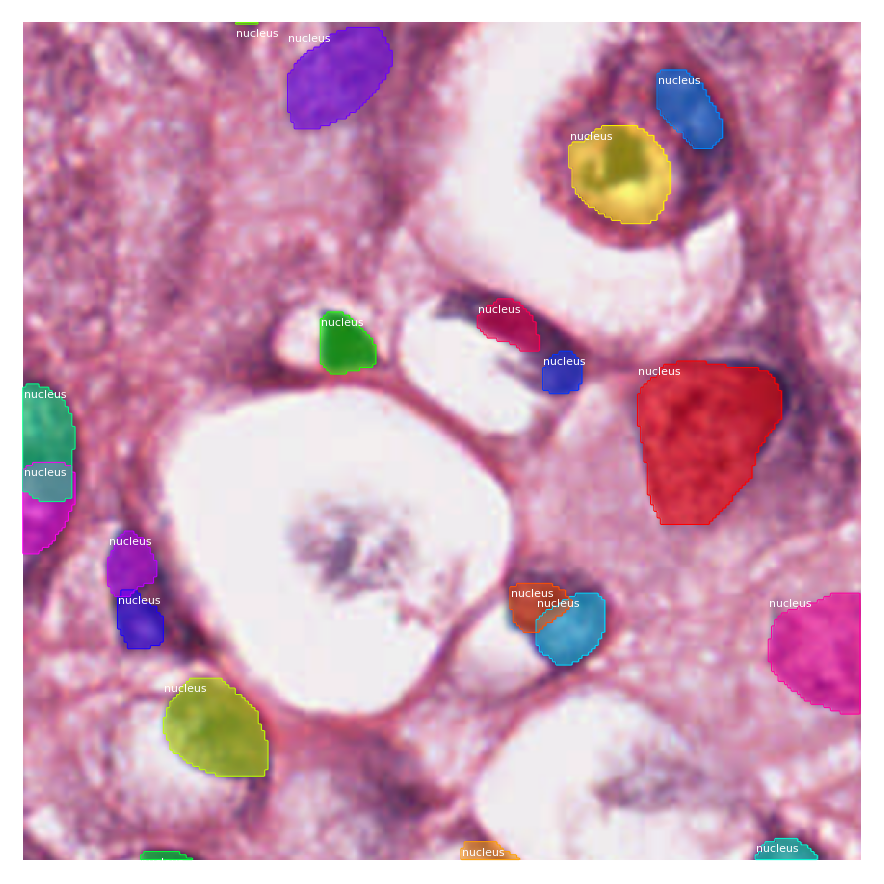

'image = dataset.load_image(image_id)\nmask, class_ids = dataset.load_mask(image_id)\n# Compute Bounding box\nbbox = utils.extract_bboxes(mask)\n\n# Display image and additional stats\nprint("image_id ", image_id, dataset.image_reference(image_id))\nlog("image", image)\nlog("mask", mask)\nlog("class_ids", class_ids)\nlog("bbox", bbox)\n# Display image and instances\nvisualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)'

In [ ]:
# Load random image and mask.
import random
image_id = 50#random.choice(dataset.image_ids)
# Load and display
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
        dataset, config, image_id, use_mini_mask=False)
log("molded_image", image)
log("mask", mask)
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names, show_bbox=False)
'''image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)'''

In [ ]:
# List of augmentations
# http://imgaug.readthedocs.io/en/latest/source/augmenters.html
augmentation = iaa.Sometimes(0.9, [
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.Multiply((0.8, 1.2)),
    iaa.GaussianBlur(sigma=(0.0, 5.0))
])

In [ ]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

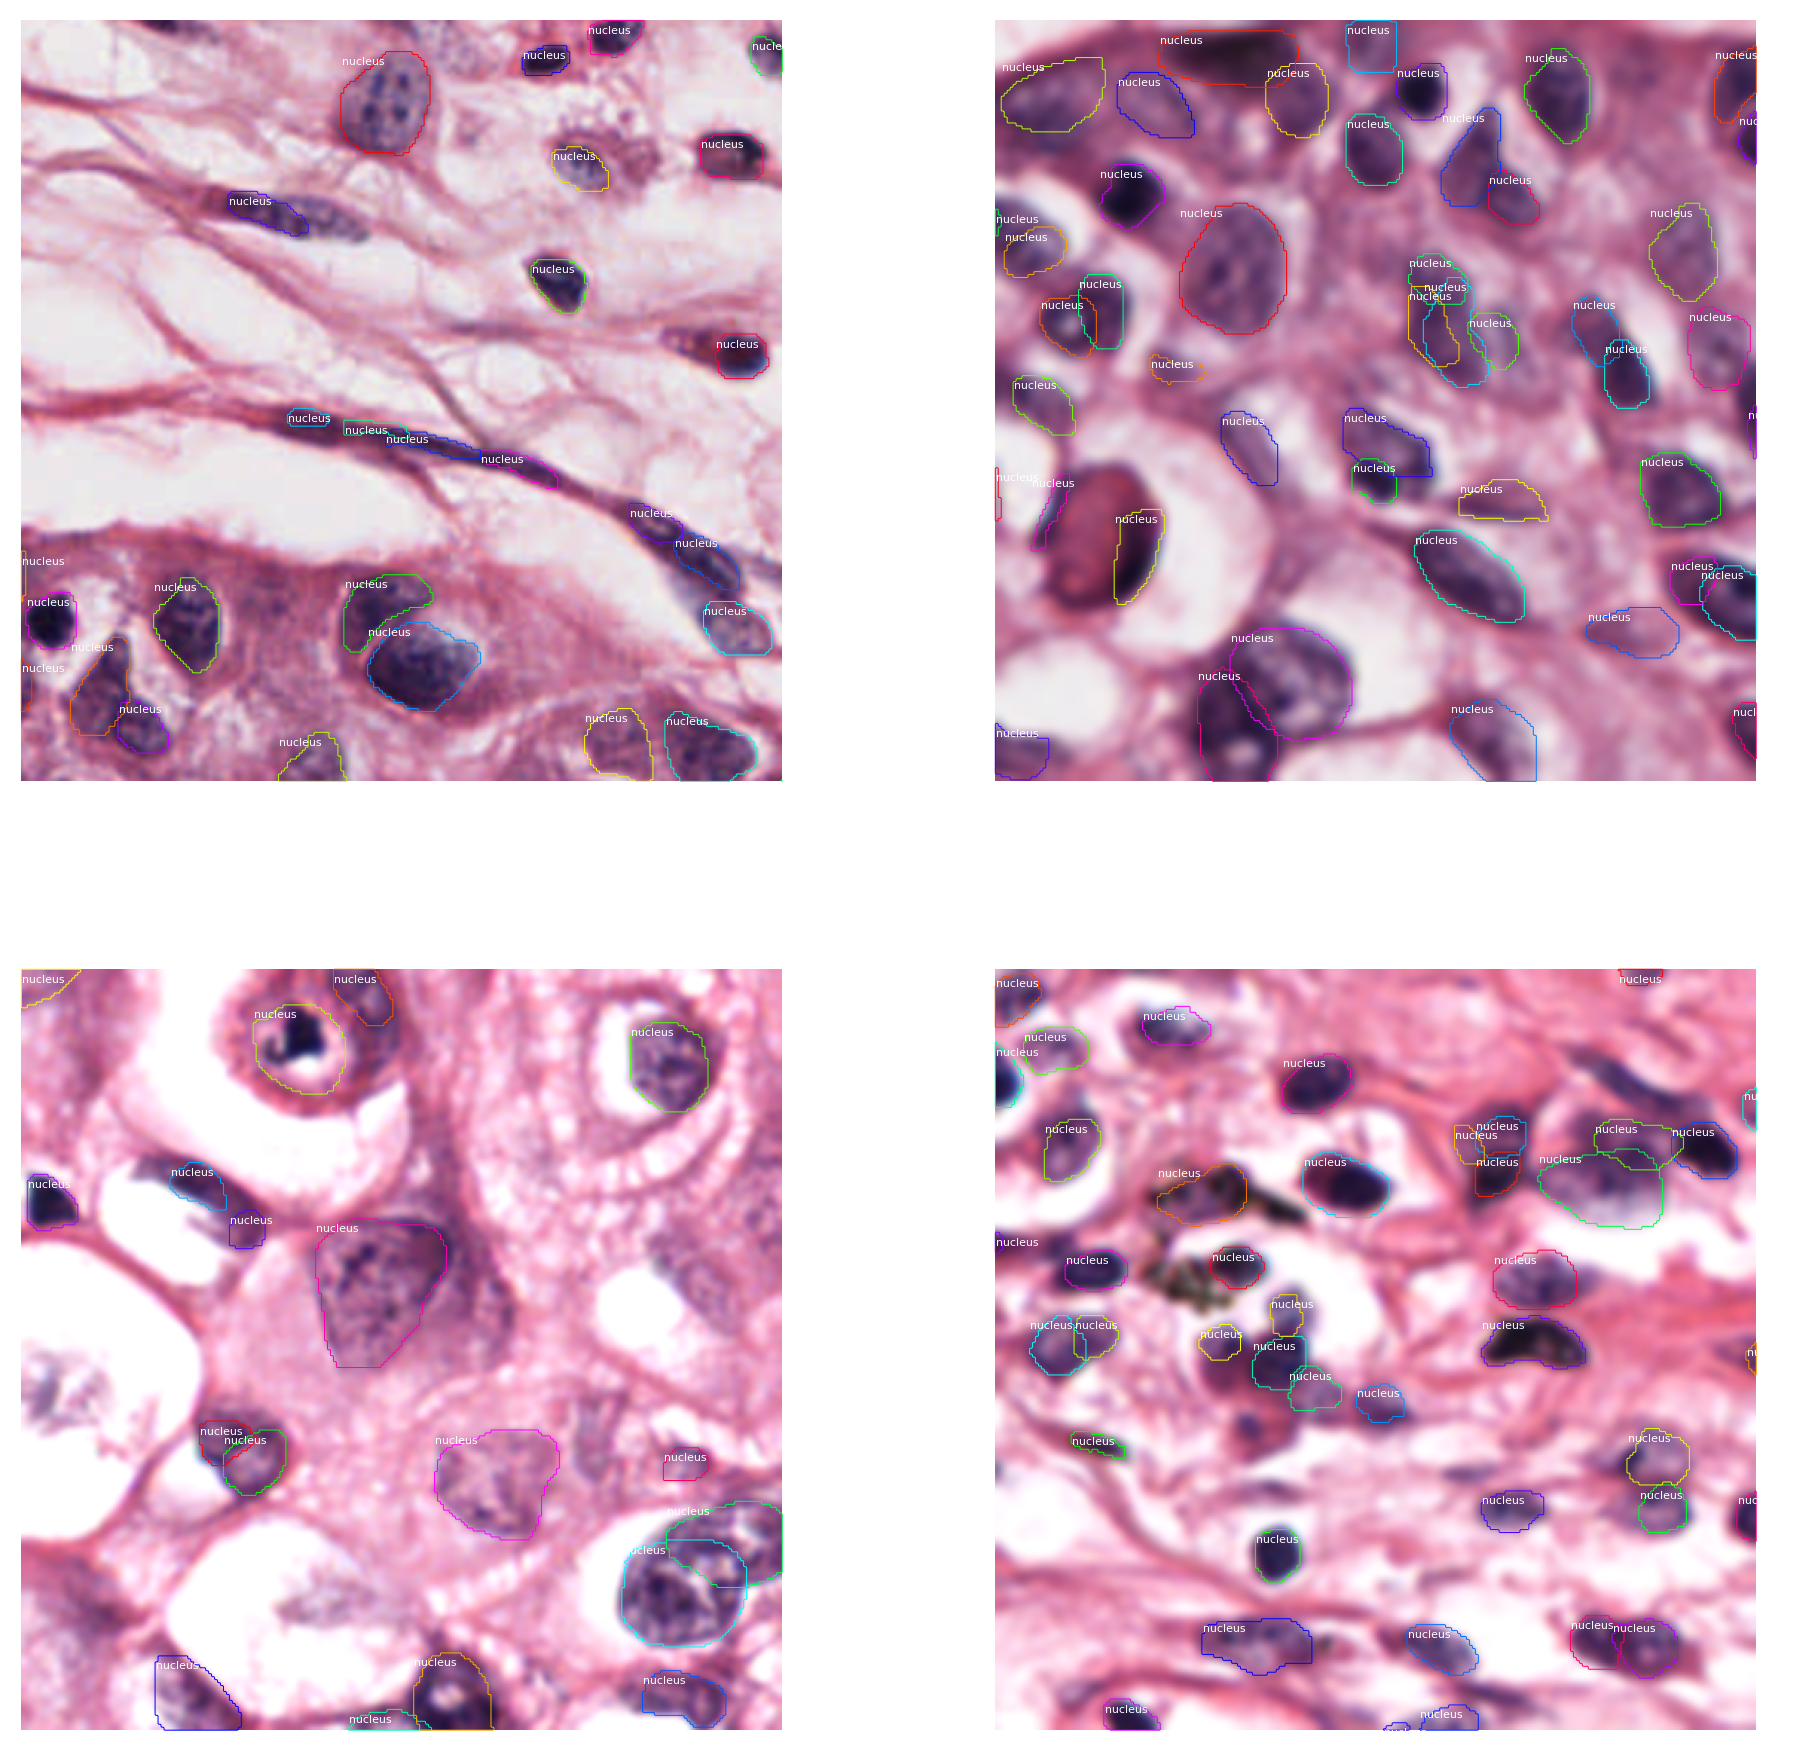

In [ ]:
# Load the image multiple times to show augmentations
limit = 4
ax = get_ax(rows=2, cols=limit//2)
for i in range(limit):
    image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
        dataset, config, image_id, use_mini_mask=False, augment=False, augmentation=augmentation)
    visualize.display_instances(image, bbox, mask, class_ids,
                                dataset.class_names, ax=ax[i//2, i % 2],
                                show_mask=False, show_bbox=False)

image_id:  573 55f98f43c152aa0dc8bea513f8ba558cc57494b81ae4ee816977816e79629c50
Original shape:  (256, 320, 3)
image                    shape: (256, 320, 3)         min:   50.00000  max:  246.00000  uint8
mask                     shape: (256, 320, 27)        min:    0.00000  max:    1.00000  bool
class_ids                shape: (27,)                 min:    1.00000  max:    1.00000  int32
bbox                     shape: (27, 4)               min:    0.00000  max:  259.00000  int32


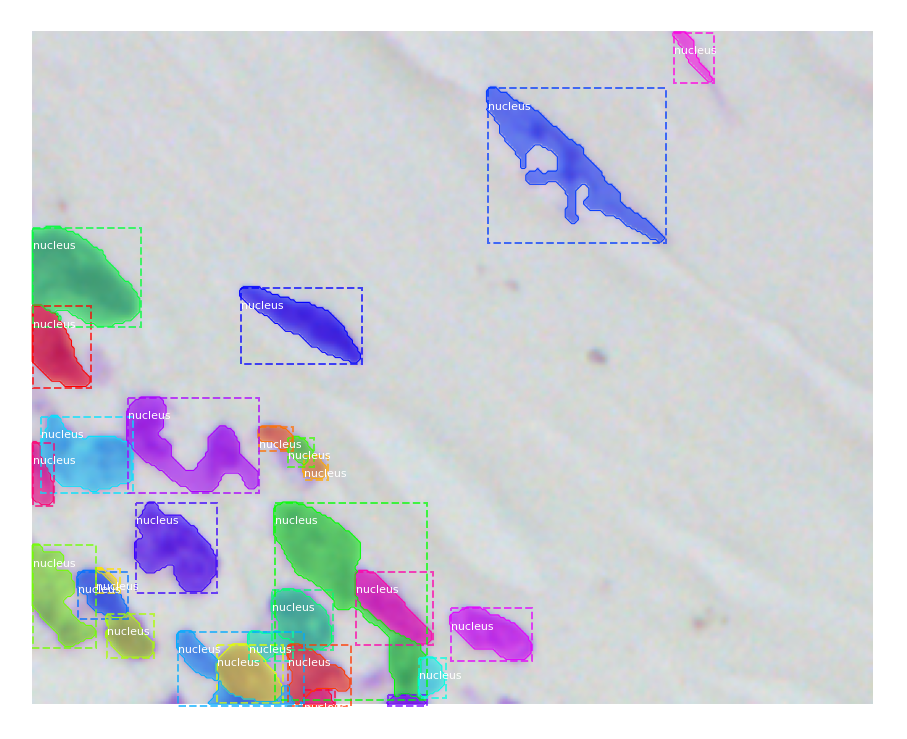

In [ ]:
# Load random image and mask.
image_id = np.random.choice(dataset.image_ids, 1)[0]
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
original_shape = image.shape
'''# Resize
image, window, scale, padding, _ = utils.resize_image(
    image, 
    min_dim=config.IMAGE_MIN_DIM, 
    max_dim=config.IMAGE_MAX_DIM,
    mode=config.IMAGE_RESIZE_MODE)
mask = utils.resize_mask(mask, scale, padding)'''
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id: ", image_id, dataset.image_reference(image_id))
print("Original shape: ", original_shape)
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

image                    shape: (512, 512, 3)         min:    0.00000  max:  218.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max:  512.00000  float64
class_ids                shape: (17,)                 min:    1.00000  max:    1.00000  int32
bbox                     shape: (17, 4)               min:    0.00000  max:  512.00000  int32
mask                     shape: (512, 512, 17)        min:    0.00000  max:    1.00000  bool


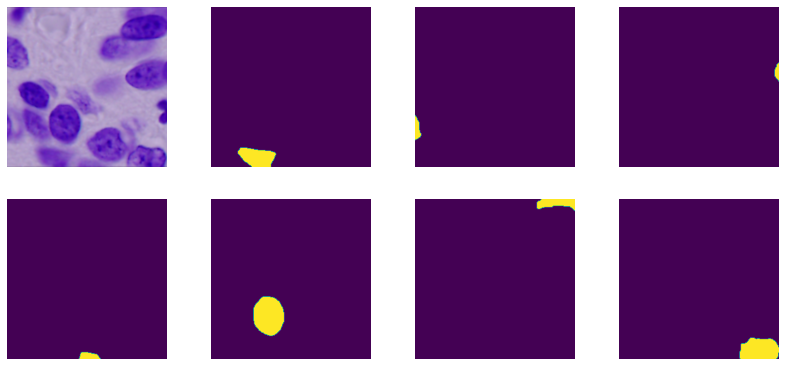

In [ ]:
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, use_mini_mask=False)

log("image", image)
log("image_meta", image_meta)
log("class_ids", class_ids)
log("bbox", bbox)
log("mask", mask)

display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

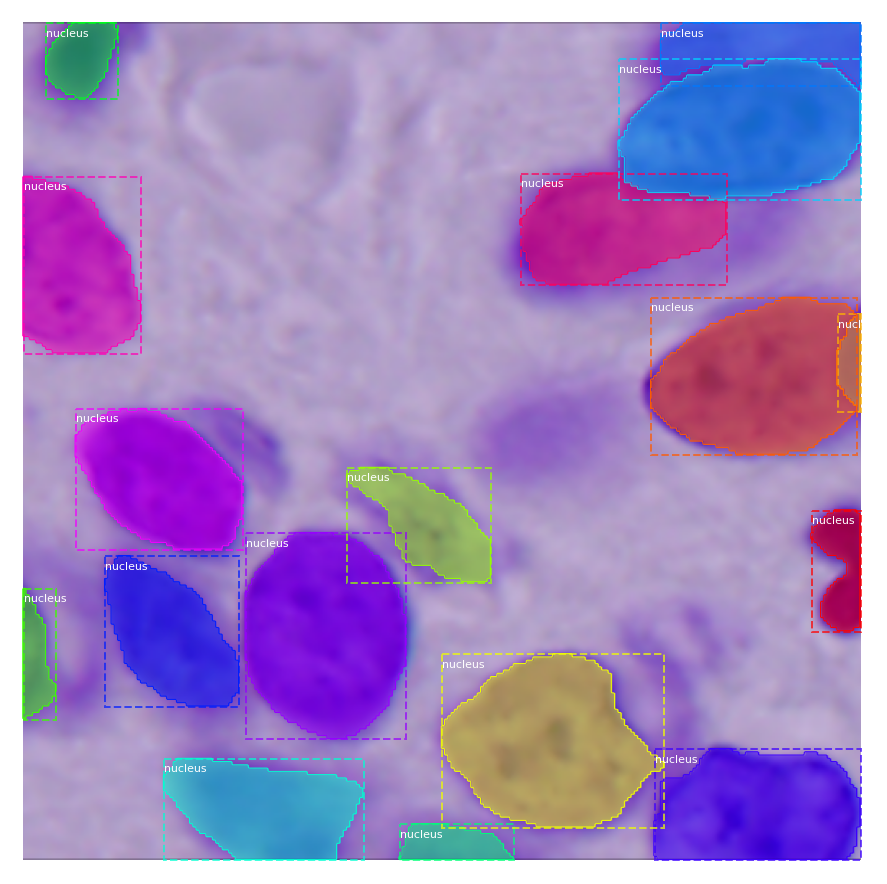

In [ ]:
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

mask                     shape: (56, 56, 17)          min:    0.00000  max:    1.00000  bool


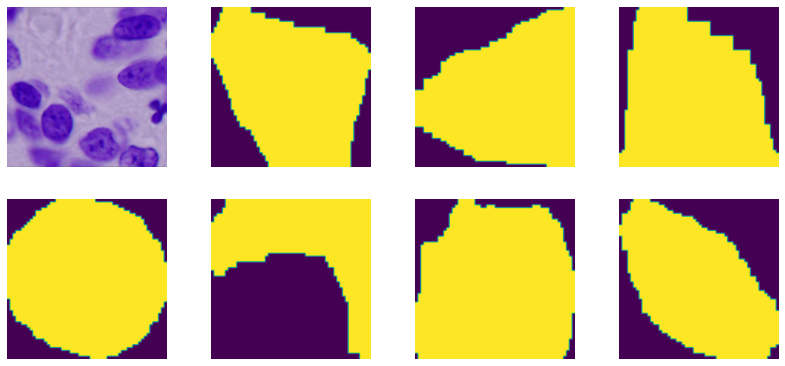

In [ ]:
# Add augmentation and mask resizing.
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, augment=True, use_mini_mask=True)
log("mask", mask)
display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

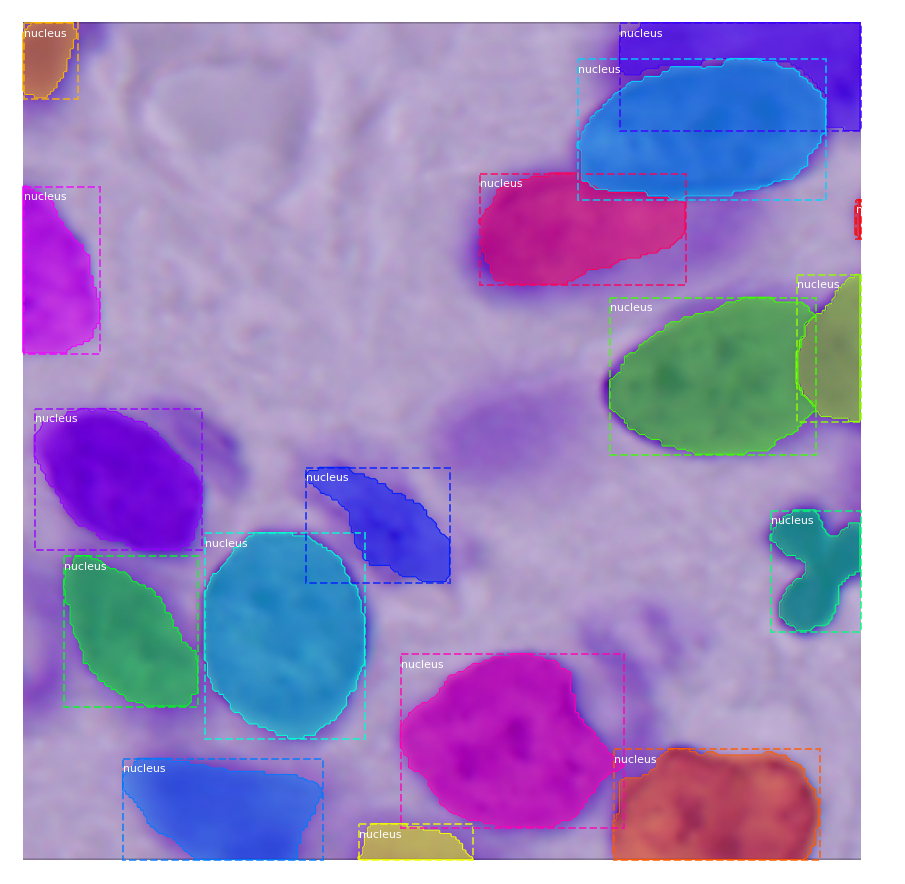

In [ ]:
mask = utils.expand_mask(bbox, mask, image.shape)
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)



### Anchors


The order of anchors is important. Use the same order in training and prediction phases. And it must match the order of the convolution execution.

For an FPN network, the anchors must be ordered in a way that makes it easy to match anchors to the output of the convolution layers that predict anchor scores and shifts.

Sort by pyramid level first. All anchors of the first level, then all of the second and so on. This makes it easier to separate anchors by level.
Within each level, sort anchors by feature map processing sequence. Typically, a convolution layer processes a feature map starting from top-left and moving right row by row.
For each feature map cell, pick any sorting order for the anchors of different ratios. Here we match the order of ratios passed to the function.
Anchor Stride: In the FPN architecture, feature maps at the first few layers are high resolution. For example, if the input image is 1024x1024 then the feature meap of the first layer is 256x256, which generates about 200K anchors (2562563). These anchors are 32x32 pixels and their stride relative to image pixels is 4 pixels, so there is a lot of overlap. We can reduce the load significantly if we generate anchors for every other cell in the feature map. A stride of 2 will cut the number of anchors by 4, for example.

In this implementation we use an anchor stride of 2, which is different from the paper.

Count:  65472
Scales:  (8, 16, 32, 64, 128)
ratios:  [0.5, 1, 2]
Anchors per Cell:  3
Levels:  5
Anchors in Level 0: 49152
Anchors in Level 1: 12288
Anchors in Level 2: 3072
Anchors in Level 3: 768
Anchors in Level 4: 192
Level 0. Anchors:  49152  Feature map Shape: [128 128]
Level 1. Anchors:  12288  Feature map Shape: [64 64]
Level 2. Anchors:   3072  Feature map Shape: [32 32]
Level 3. Anchors:    768  Feature map Shape: [16 16]
Level 4. Anchors:    192  Feature map Shape: [8 8]


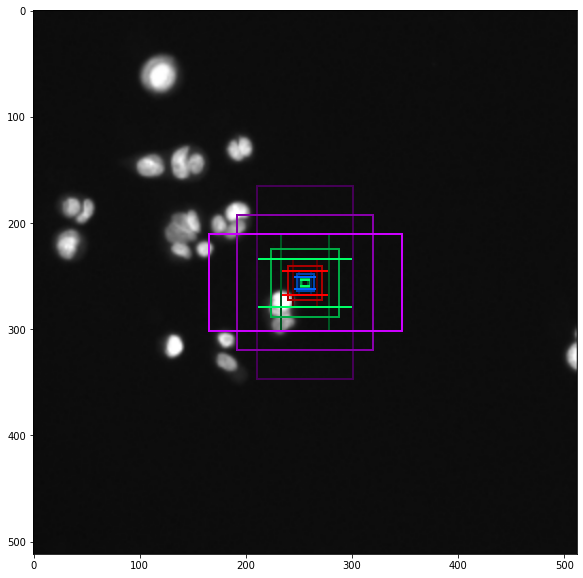

In [ ]:
## Visualize anchors of one cell at the center of the feature map

# Load and display random image
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, _, _, _ = modellib.load_image_gt(dataset,config, image_id)

# Generate Anchors
backbone_shapes = modellib.compute_backbone_shapes(config, image.shape)
anchors = utils.generate_pyramid_anchors(config.RPN_ANCHOR_SCALES, 
                                          config.RPN_ANCHOR_RATIOS,
                                          backbone_shapes,
                                          config.BACKBONE_STRIDES, 
                                          config.RPN_ANCHOR_STRIDE)

# Print summary of anchors
num_levels = len(backbone_shapes)
anchors_per_cell = len(config.RPN_ANCHOR_RATIOS)
print("Count: ", anchors.shape[0])
print("Scales: ", config.RPN_ANCHOR_SCALES)
print("ratios: ", config.RPN_ANCHOR_RATIOS)
print("Anchors per Cell: ", anchors_per_cell)
print("Levels: ", num_levels)
anchors_per_level = []
for l in range(num_levels):
    num_cells = backbone_shapes[l][0] * backbone_shapes[l][1]
    anchors_per_level.append(anchors_per_cell * num_cells // config.RPN_ANCHOR_STRIDE**2)
    print("Anchors in Level {}: {}".format(l, anchors_per_level[l]))

# Display
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(image)
levels = len(backbone_shapes)

for level in range(levels):
    colors = visualize.random_colors(levels)
    # Compute the index of the anchors at the center of the image
    level_start = sum(anchors_per_level[:level]) # sum of anchors of previous levels
    level_anchors = anchors[level_start:level_start+anchors_per_level[level]]
    print("Level {}. Anchors: {:6}  Feature map Shape: {}".format(level, level_anchors.shape[0], 
                                                                backbone_shapes[level]))
    center_cell = backbone_shapes[level] // 2
    center_cell_index = (center_cell[0] * backbone_shapes[level][1] + center_cell[1])
    level_center = center_cell_index * anchors_per_cell 
    center_anchor = anchors_per_cell * (
        (center_cell[0] * backbone_shapes[level][1] / config.RPN_ANCHOR_STRIDE**2) \
        + center_cell[1] / config.RPN_ANCHOR_STRIDE)
    level_center = int(center_anchor)

    # Draw anchors. Brightness show the order in the array, dark to bright.
    for i, rect in enumerate(level_anchors[level_center:level_center+anchors_per_cell]):
        y1, x1, y2, x2 = rect
        p = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, facecolor='none',
                              edgecolor=(i+1)*np.array(colors[level]) / anchors_per_cell)
        ax.add_patch(p)


### Data Generator

In [ ]:
# Create data generator
random_rois = 2000
g = modellib.data_generator(
    dataset, config, shuffle=True, random_rois=random_rois, 
    batch_size=4,
    detection_targets=True)

In [ ]:
# Get Next Image
if random_rois:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_class_ids, gt_boxes, gt_masks, rpn_rois, rois], \
    [mrcnn_class_ids, mrcnn_bbox, mrcnn_mask] = next(g)
    
    log("rois", rois)
    log("mrcnn_class_ids", mrcnn_class_ids)
    log("mrcnn_bbox", mrcnn_bbox)
    log("mrcnn_mask", mrcnn_mask)
else:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_boxes, gt_masks], _ = next(g)
    
log("gt_class_ids", gt_class_ids)
log("gt_boxes", gt_boxes)
log("gt_masks", gt_masks)
log("rpn_match", rpn_match, )
log("rpn_bbox", rpn_bbox)
image_id = modellib.parse_image_meta(image_meta)["image_id"][0]
print("image_id: ", image_id, dataset.image_reference(image_id))

# Remove the last dim in mrcnn_class_ids. It's only added
# to satisfy Keras restriction on target shape.
mrcnn_class_ids = mrcnn_class_ids[:,:,0]

rois                     shape: (4, 512, 4)           min:    0.00000  max:  511.00000  int32
mrcnn_class_ids          shape: (4, 512, 1)           min:    0.00000  max:    1.00000  int32
mrcnn_bbox               shape: (4, 512, 2, 4)        min:   -3.46154  max:    2.64706  float32
mrcnn_mask               shape: (4, 512, 28, 28, 2)   min:    0.00000  max:    1.00000  float32
gt_class_ids             shape: (4, 500)              min:    0.00000  max:    1.00000  int32
gt_boxes                 shape: (4, 500, 4)           min:    0.00000  max:  512.00000  int32
gt_masks                 shape: (4, 56, 56, 500)      min:    0.00000  max:    1.00000  bool
rpn_match                shape: (4, 65472, 1)         min:   -1.00000  max:    1.00000  int32
rpn_bbox                 shape: (4, 320, 4)           min:   -3.53553  max:    3.97748  float64
image_id:  561 4d09672bcf5a2661eea00891bbb8191225a06619a849aece37ad10d9dedbde3e


anchors                  shape: (65472, 4)            min:  -90.50967  max:  538.50967  float64
refined_anchors          shape: (10, 4)               min:   -0.00000  max:  512.00000  float32
Positive anchors: 10
Negative anchors: 310
Neutral anchors: 65152
BG                     : 485
nucleus                : 27


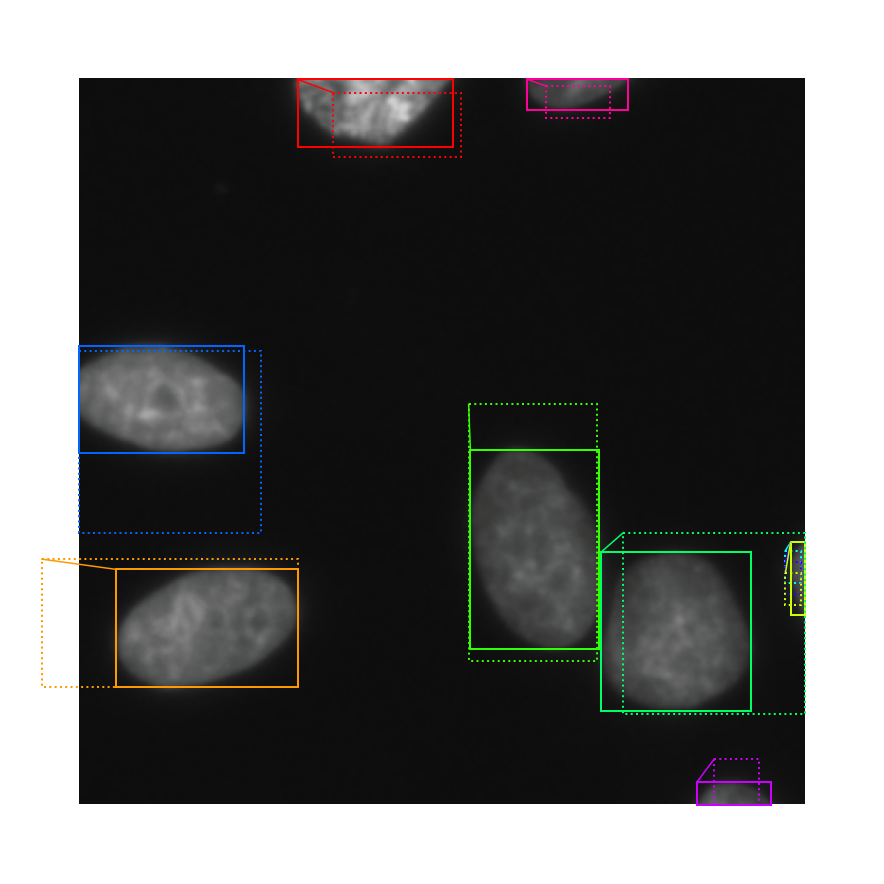

In [ ]:
b = 0

# Restore original image (reverse normalization)
sample_image = modellib.unmold_image(normalized_images[b], config)

# Compute anchor shifts.
indices = np.where(rpn_match[b] == 1)[0]
refined_anchors = utils.apply_box_deltas(anchors[indices], rpn_bbox[b, :len(indices)] * config.RPN_BBOX_STD_DEV)
log("anchors", anchors)
log("refined_anchors", refined_anchors)

# Get list of positive anchors
positive_anchor_ids = np.where(rpn_match[b] == 1)[0]
print("Positive anchors: {}".format(len(positive_anchor_ids)))
negative_anchor_ids = np.where(rpn_match[b] == -1)[0]
print("Negative anchors: {}".format(len(negative_anchor_ids)))
neutral_anchor_ids = np.where(rpn_match[b] == 0)[0]
print("Neutral anchors: {}".format(len(neutral_anchor_ids)))

# ROI breakdown by class
for c, n in zip(dataset.class_names, np.bincount(mrcnn_class_ids[b].flatten())):
    if n:
        print("{:23}: {}".format(c[:20], n))

# Show positive anchors
fig, ax = plt.subplots(1, figsize=(16, 16))
visualize.draw_boxes(sample_image, boxes=anchors[positive_anchor_ids], 
                     refined_boxes=refined_anchors, ax=ax)

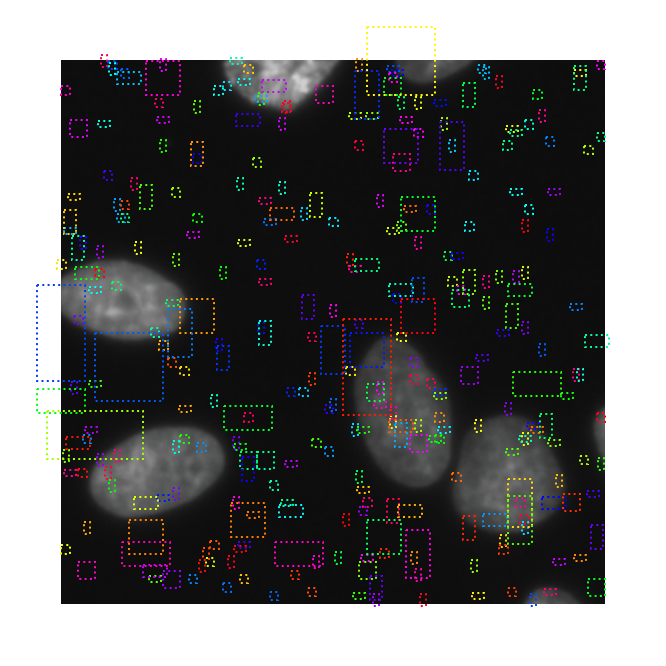

In [ ]:
# Show negative anchors
visualize.draw_boxes(sample_image, boxes=anchors[negative_anchor_ids])

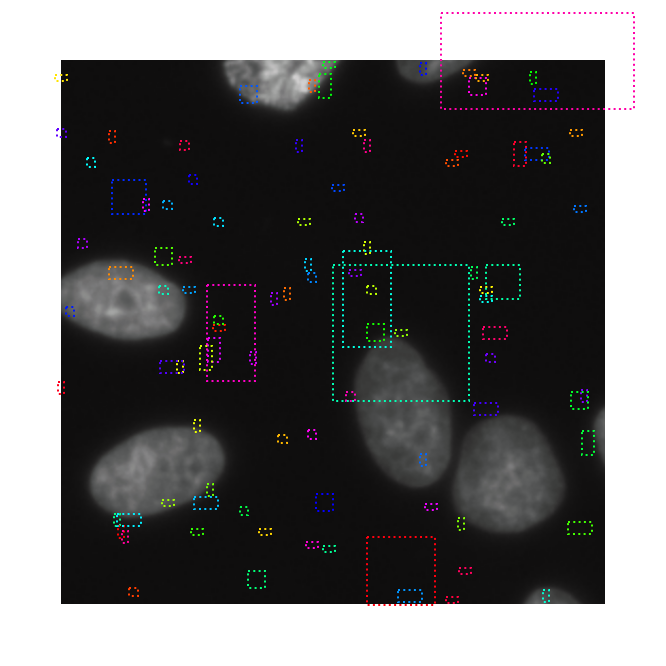

In [ ]:
# Show neutral anchors. They don't contribute to training.
visualize.draw_boxes(sample_image, boxes=anchors[np.random.choice(neutral_anchor_ids, 100)])

### ROIs

Positive ROIs:  27
Negative ROIs:  485
Positive Ratio: 0.05
Unique ROIs: 512 out of 512


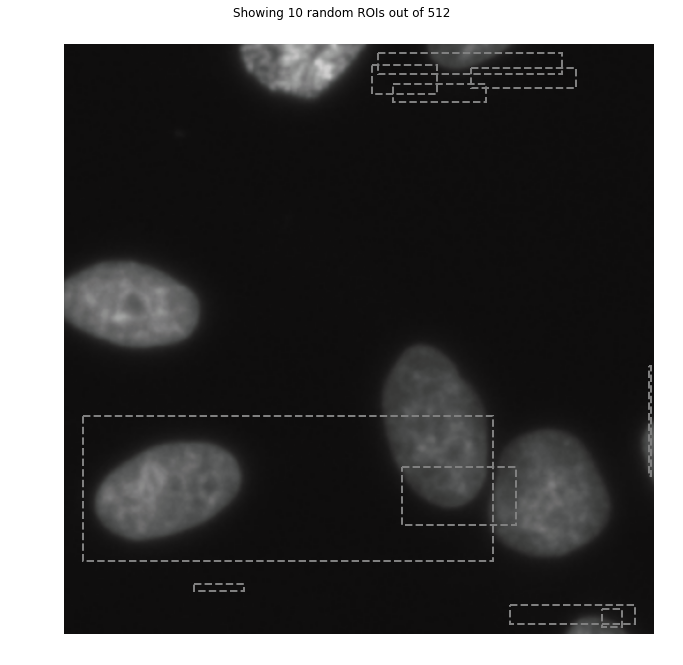

In [ ]:
if random_rois:
    # Class aware bboxes
    bbox_specific = mrcnn_bbox[b, np.arange(mrcnn_bbox.shape[1]), mrcnn_class_ids[b], :]

    # Refined ROIs
    refined_rois = utils.apply_box_deltas(rois[b].astype(np.float32), bbox_specific[:,:4] * config.BBOX_STD_DEV)

    # Class aware masks
    mask_specific = mrcnn_mask[b, np.arange(mrcnn_mask.shape[1]), :, :, mrcnn_class_ids[b]]

    visualize.draw_rois(sample_image, rois[b], refined_rois, mask_specific, mrcnn_class_ids[b], dataset.class_names)
    
    # Any repeated ROIs?
    rows = np.ascontiguousarray(rois[b]).view(np.dtype((np.void, rois.dtype.itemsize * rois.shape[-1])))
    _, idx = np.unique(rows, return_index=True)
    print("Unique ROIs: {} out of {}".format(len(idx), rois.shape[1]))

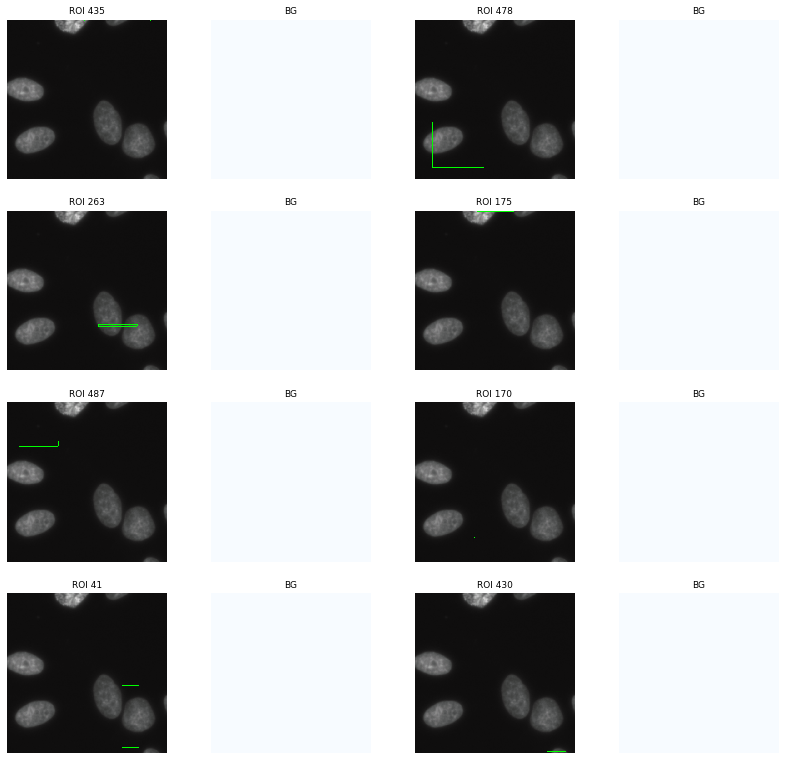

In [ ]:
if random_rois:
    # Dispalay ROIs and corresponding masks and bounding boxes
    ids = random.sample(range(rois.shape[1]), 8)

    images = []
    titles = []
    for i in ids:
        image = visualize.draw_box(sample_image.copy(), rois[b,i,:4].astype(np.int32), [255, 0, 0])
        image = visualize.draw_box(image, refined_rois[i].astype(np.int64), [0, 255, 0])
        images.append(image)
        titles.append("ROI {}".format(i))
        images.append(mask_specific[i] * 255)
        titles.append(dataset.class_names[mrcnn_class_ids[b,i]][:20])

    display_images(images, titles, cols=4, cmap="Blues", interpolation="none")

In [ ]:
# Check ratio of positive ROIs in a set of images.
if random_rois:
    limit = 10
    temp_g = modellib.data_generator(
        dataset, config, shuffle=True, random_rois=10000, 
        batch_size=1, detection_targets=True)
    total = 0
    for i in range(limit):
        _, [ids, _, _] = next(temp_g)
        positive_rois = np.sum(ids[0] > 0)
        total += positive_rois
        print("{:5} {:5.2f}".format(positive_rois, positive_rois/ids.shape[1]))
    print("Average percent: {:.2f}".format(total/(limit*ids.shape[1])))

  101  0.20
  112  0.22
  168  0.33
  168  0.33
  124  0.24
  158  0.31
  168  0.33
  131  0.26
  161  0.31
  141  0.28
Average percent: 0.28
